In [53]:
print(__doc__)

import scipy.stats as scp_stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.special import expit

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn import metrics

import missingno as msno
import seaborn as sns

# pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format
df = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/ML-for-COVID-19-dataset/main/all_training.csv", sep=',')


Automatically created module for IPython interactive environment


In [54]:
#Using robust scaling as normalization method

# Column selection
df_features = df.iloc[:,np.r_[3,5:34]].copy()

# create a scaler object
scaler = RobustScaler()

# fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
n_samples, n_features = df_features.shape

# How many nan values are there?
df_normalized.isna().sum()

CA       93
CREA     74
ALP     474
GGT     436
GLU      98
AST      98
ALT      96
LDH     303
PCR      97
KAL      80
NAT      73
UREA    676
WBC      63
RBC      63
HGB      63
HCT      63
MCV      63
MCH      63
MCHC     63
PLT1     63
NE      362
LY      362
MO      362
EO      362
BA      362
NET     362
LYT     362
MOT     362
EOT     362
BAT     362
dtype: int64

In [55]:
# %matplotlib inline
# # msno.matrix(df)
# msno.matrix(df_normalized)
# # msno.heatmap(df_normalized)

In [56]:
# define row and column index
col = df_normalized.columns
row = [i for i in range(df_normalized.shape[0])]

# define imputer
imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

# fit on the dataset
imputer.fit(df_normalized)

# transform the dataset
df_normalized_imputed = imputer.transform(df_normalized)

# convert back to pandas dataframe and rename back to df_normalized
df_normalized = pd.DataFrame(data=df_normalized_imputed, index=row, columns=col)

# how many values does the imputation fix?
df_normalized.isna().sum()

/Users/wenxuanhuang/Library/Python/3.8/lib/python/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


CA      0
CREA    0
ALP     0
GGT     0
GLU     0
AST     0
ALT     0
LDH     0
PCR     0
KAL     0
NAT     0
UREA    0
WBC     0
RBC     0
HGB     0
HCT     0
MCV     0
MCH     0
MCHC    0
PLT1    0
NE      0
LY      0
MO      0
EO      0
BA      0
NET     0
LYT     0
MOT     0
EOT     0
BAT     0
dtype: int64

In [57]:
# # The indices of the features that we are plotting
# x_index = 4
# y_index = 5

# # this formatter will label the colorbar with the correct target names
# formatter = plt.FuncFormatter(lambda i, *args: df.target.unique()[int(i)])

# plt.figure(figsize=(5, 4))
# plt.scatter(df_normalized.iloc[:, x_index], df_normalized.iloc[:, y_index], c=df.target)
# plt.colorbar(ticks=[0, 1], format=formatter)
# plt.xlabel(df_normalized.columns[x_index])
# plt.ylabel(df_normalized.columns[y_index])

# plt.tight_layout()
# plt.show()

In [58]:
# # Plotting histogram
# plt.hist(df.target)  

In [59]:
# # Plotting target dist for each features
# for index, feature_name in enumerate(df_normalized.columns):
#     plt.figure()
#     plt.scatter(df_normalized.iloc[:, index], df.target)
#     plt.xlabel(df_normalized.columns[index])
#     plt.ylabel("Target")
#     plt.tight_layout()
#     plt.show()

In [60]:
# Random forest regression

# Data preparation
X = df_normalized
y = df.target

#Recursive feature elimination

rdmreg = RandomForestClassifier(n_estimators=100)
# Define the method
rfe = RFE(estimator=rdmreg, n_features_to_select=10)
# Fit the model
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
# print(rfe.ranking_)

# Drop columns that failed RFE test
col = df_normalized.columns[rfe.support_]
X = X[col]
X = X.to_numpy()

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# The line is disabled since single column has not been specified 
#X = X[:, np.newaxis]

[ True False False False False  True False  True  True False False False
  True  True False False False False False False False False False  True
 False  True  True False  True False]


In [61]:
# Create a Gaussian Classifier
svc_skmodel=svm.SVC(kernel='linear')
# Train the random forest model
svc_skmodel.fit(X_train,y_train)

# Predict the response for test dataset
y_pred=svc_skmodel.predict(X_test)
# Model Accuracy: How often is the classifier correct?
print(metrics.accuracy_score(y_test, y_pred))

0.8119001919385797


In [62]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.8232758620689655
Recall: 0.7701612903225806


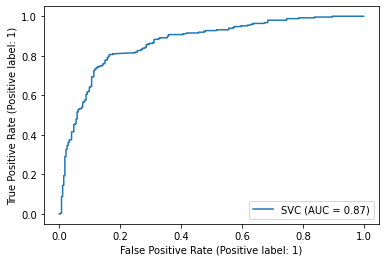

In [63]:
svc_disp = metrics.plot_roc_curve(svc_skmodel, X_test, y_test)

In [64]:
!pip3 install plotly --upgrade
import plotly.graph_objects as go

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [65]:
Z = lambda X,Y: (-clf.intercept_[0]-clf.coef_[0][0]*X-clf.coef_[0][1]*Y) / clf.coef_[0][2]

trace1 = go.Mesh3d(x = X_train[:,2], y = X_train[:,3], z = Z(X_train[:,2],X_train[:,3])) ## for separating plane
trace2 = go.Scatter3d(x=X_train[:,2], y=X_train[:,3],z=X_train[:,4],mode='markers',marker = dict(size = 3,color = y_train,colorscale = 'Viridis')) ## for vector plots
data=[trace1,trace2]
fig = go.Figure(data=data,layout={})
fig.show()

NameError: name 'clf' is not defined